# Final Project - Reinforcements Learning - Ex1

---

<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

Full Notebook:
### https://colab.research.google.com/drive/1umfxWIoivhACC9YcWRZIxINsZch9JEaC?usp=sharing

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!pip install stable-baselines3[extra]
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip
!git clone https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission.git


# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import torch.nn.functional as F
from itertools import count
from stable_baselines3 import PPO
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
assert torch.cuda.is_available()

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

#Utils

In [ ]:
def conv2d_size_out(size, kernel_size=5, stride=2):
    return (size - (kernel_size - 1) - 1) // stride + 1

h, w, c = sok.observation_space.shape


def save_checkpoint(filename, policy_model):
    checkpoint = {
        'policy_model_state_dict': policy_model.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(filename, policy_model, target_model):
    checkpoint = torch.load(filename)
    policy_model.load_state_dict(checkpoint['policy_model_state_dict'])
    target_model.load_state_dict(policy_model.state_dict())
    target_model.eval()


def plot_model_performance(mean_rewards, mean_lengths):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(mean_rewards)
  plt.title('Mean Episodic Reward')
  plt.xlabel('Episode')
  plt.ylabel('Mean Reward')

  plt.subplot(1, 2, 2)
  plt.plot(mean_lengths)
  plt.title('Mean Episodic Length')
  plt.xlabel('Episode')
  plt.ylabel('Mean Length')

  plt.show()

#DQN Model

In [ ]:
# Calculate the dimensions after passing through all the convolutional layers
convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
linear_input_size = convw * convh * 32  # 32 is the output channel size of the last conv layer

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#Experience Replay

In [ ]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#Training

In [ ]:
# Hyperparameters
BATCH_SIZE = 256
GAMMA = 0.95       #was 0.999
EPS_START = 1.0    # was 0.9
EPS_END = 0.1      # was 0.05
EPS_DECAY = 20000  #was 10,000
TARGET_UPDATE = 5

# Bad way to update epsilon
steps_done = 0

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the DQN and target network
n_actions = sok.action_space.n
policy_net = DQN(h, w, n_actions).to(device)
target_net = DQN(h, w, n_actions).to(device)

# Optimizer and Memory
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Experience(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=100):

  total_rewards = 0
  total_lengths = 0
  mean_rewards = []
  mean_lengths = []

  for i_episode in tqdm(range(num_episodes)):

    episode_reward = 0.0

    state_array = sok.reset()
    state = torch.tensor(state_array.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)

    previous_player_position = None

    # Save once every 10 episodes
    if (i_episode + 1) % 10 == 0:
      save_checkpoint("DQN-checkpoint-v1-ep" + str(i_episode), policy_net)

    for t in range(max_steps_per_episode):
      action = select_action(state)
      next_state, reward, done, info = sok.step(action.item())

      # Check if the episode ended and was successful
      if done and t < 250:
        reward += 10

      # Check if the box has not moved and penalize
      if not info['action.moved_box']:
          reward -= 0.1
      else:
          reward += 0.1

      current_player_position = sok.player_position
      if np.array_equal(previous_player_position, current_player_position):
        reward -= 0.1


      previous_player_position = current_player_position
      episode_reward += reward

      next_state = torch.tensor(next_state.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)
      reward = torch.tensor([reward], device=device)
      memory.push(state, action, next_state, reward, done)
      state = next_state

      optimize_model()
      if done:
          break

    total_rewards += episode_reward
    total_lengths += t + 1

    mean_episodic_reward = total_rewards / (i_episode + 1)
    mean_episodic_length = total_lengths / (i_episode + 1)

    mean_rewards.append(mean_episodic_reward)
    mean_lengths.append(mean_episodic_length)

    print()
    print("=" * 20 + "Training Progress " + "Episode " + str(i_episode + 1) + "=" * 20)
    print("Mean Episode Reward: ", mean_episodic_reward)
    print("Mean Episode Length: ", mean_episodic_length)
    print(f"Current Episode Reward: {episode_reward}")
    print(f"Current Episode Length: {t + 1}")

    print()



    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

  return mean_rewards, mean_lengths

# Train Model

In [ ]:
mean_rewards, mean_lengths = train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=300)

  0%|          | 1/300 [00:09<45:57,  9.22s/it]


====================Training Progress Episode 1====================
Mean Episode Reward:  -118.00000000000017
Mean Episode Length:  500.0
Current Episode Reward: -118.00000000000017
Current Episode Length: 500



  1%|          | 2/300 [00:26<1:09:12, 13.93s/it]


====================Training Progress Episode 2====================
Mean Episode Reward:  -116.0500000000003
Mean Episode Length:  500.0
Current Episode Reward: -114.10000000000043
Current Episode Length: 500



  1%|          | 3/300 [00:27<38:52,  7.85s/it]  


====================Training Progress Episode 3====================
Mean Episode Reward:  -71.5000000000002
Mean Episode Length:  339.3333333333333
Current Episode Reward: 17.599999999999998
Current Episode Length: 18


====================Training Progress Episode 4====================
Mean Episode Reward:  -48.37500000000015
Mean Episode Length:  254.75
Current Episode Reward: 21.0
Current Episode Length: 1



  2%|▏         | 5/300 [00:27<18:02,  3.67s/it]


====================Training Progress Episode 5====================
Mean Episode Reward:  -35.70000000000012
Mean Episode Length:  209.0
Current Episode Reward: 15.0
Current Episode Length: 26



  2%|▏         | 6/300 [00:34<22:11,  4.53s/it]


====================Training Progress Episode 6====================
Mean Episode Reward:  -34.00000000000009
Mean Episode Length:  206.83333333333334
Current Episode Reward: -25.49999999999995
Current Episode Length: 196


====================Training Progress Episode 7====================
Mean Episode Reward:  -26.171428571428645
Mean Episode Length:  177.57142857142858
Current Episode Reward: 20.8
Current Episode Length: 2



  3%|▎         | 8/300 [00:34<12:23,  2.55s/it]


====================Training Progress Episode 8====================
Mean Episode Reward:  -20.350000000000065
Mean Episode Length:  156.125
Current Episode Reward: 20.4
Current Episode Length: 6



  3%|▎         | 9/300 [00:52<30:30,  6.29s/it]


====================Training Progress Episode 9====================
Mean Episode Reward:  -30.90000000000009
Mean Episode Length:  194.33333333333334
Current Episode Reward: -115.30000000000032
Current Episode Length: 500



  3%|▎         | 10/300 [01:10<44:23,  9.18s/it]


====================Training Progress Episode 10====================
Mean Episode Reward:  -39.22000000000011
Mean Episode Length:  224.9
Current Episode Reward: -114.10000000000032
Current Episode Length: 500



  4%|▎         | 11/300 [01:16<40:53,  8.49s/it]


====================Training Progress Episode 11====================
Mean Episode Reward:  -37.59090909090919
Mean Episode Length:  221.54545454545453
Current Episode Reward: -21.30000000000002
Current Episode Length: 188



  4%|▍         | 12/300 [01:34<52:33, 10.95s/it]


====================Training Progress Episode 12====================
Mean Episode Reward:  -44.03333333333345
Mean Episode Length:  244.75
Current Episode Reward: -114.90000000000032
Current Episode Length: 500



  4%|▍         | 13/300 [01:35<38:47,  8.11s/it]


====================Training Progress Episode 13====================
Mean Episode Reward:  -39.538461538461654
Mean Episode Length:  228.07692307692307
Current Episode Reward: 14.399999999999999
Current Episode Length: 28



  5%|▍         | 14/300 [01:52<51:24, 10.78s/it]


====================Training Progress Episode 14====================
Mean Episode Reward:  -44.96428571428583
Mean Episode Length:  247.5
Current Episode Reward: -115.50000000000009
Current Episode Length: 500



  5%|▌         | 15/300 [02:10<1:00:34, 12.75s/it]


====================Training Progress Episode 15====================
Mean Episode Reward:  -49.64000000000013
Mean Episode Length:  264.3333333333333
Current Episode Reward: -115.1000000000004
Current Episode Length: 500



  5%|▌         | 16/300 [02:18<54:21, 11.48s/it]  


====================Training Progress Episode 16====================
Mean Episode Reward:  -48.69375000000013
Mean Episode Length:  262.9375
Current Episode Reward: -34.500000000000064
Current Episode Length: 242



  6%|▌         | 17/300 [02:35<1:02:24, 13.23s/it]


====================Training Progress Episode 17====================
Mean Episode Reward:  -52.605882352941315
Mean Episode Length:  276.88235294117646
Current Episode Reward: -115.20000000000029
Current Episode Length: 500



  6%|▌         | 18/300 [02:47<59:59, 12.76s/it]  


====================Training Progress Episode 18====================
Mean Episode Reward:  -53.27777777777792
Mean Episode Length:  280.0
Current Episode Reward: -64.70000000000024
Current Episode Length: 333



  6%|▋         | 19/300 [03:04<1:06:12, 14.14s/it]


====================Training Progress Episode 19====================
Mean Episode Reward:  -56.552631578947526
Mean Episode Length:  291.57894736842104
Current Episode Reward: -115.50000000000028
Current Episode Length: 500



  7%|▋         | 20/300 [03:05<47:09, 10.10s/it]  


====================Training Progress Episode 20====================
Mean Episode Reward:  -52.90500000000014
Mean Episode Length:  277.9
Current Episode Reward: 16.4
Current Episode Length: 18



  7%|▋         | 21/300 [03:23<57:11, 12.30s/it]


====================Training Progress Episode 21====================
Mean Episode Reward:  -55.657142857143015
Mean Episode Length:  288.4761904761905
Current Episode Reward: -110.7000000000005
Current Episode Length: 500



  7%|▋         | 22/300 [03:40<1:04:01, 13.82s/it]


====================Training Progress Episode 22====================
Mean Episode Reward:  -58.28181818181835
Mean Episode Length:  298.09090909090907
Current Episode Reward: -113.40000000000036
Current Episode Length: 500



  8%|▊         | 23/300 [03:57<1:08:51, 14.91s/it]


====================Training Progress Episode 23====================
Mean Episode Reward:  -61.256521739130584
Mean Episode Length:  306.8695652173913
Current Episode Reward: -126.69999999999985
Current Episode Length: 500



  8%|▊         | 24/300 [04:05<57:57, 12.60s/it]  


====================Training Progress Episode 24====================
Mean Episode Reward:  -60.06250000000014
Mean Episode Length:  302.75
Current Episode Reward: -32.59999999999992
Current Episode Length: 208



  8%|▊         | 25/300 [04:05<40:49,  8.91s/it]


====================Training Progress Episode 25====================
Mean Episode Reward:  -56.87600000000014
Mean Episode Length:  290.96
Current Episode Reward: 19.6
Current Episode Length: 8



  9%|▊         | 26/300 [04:08<33:00,  7.23s/it]


====================Training Progress Episode 26====================
Mean Episode Reward:  -54.67692307692322
Mean Episode Length:  283.38461538461536
Current Episode Reward: 0.3000000000000078
Current Episode Length: 94



  9%|▉         | 27/300 [04:10<26:07,  5.74s/it]


====================Training Progress Episode 27====================
Mean Episode Reward:  -52.45555555555569
Mean Episode Length:  275.22222222222223
Current Episode Reward: 5.299999999999995
Current Episode Length: 63



  9%|▉         | 28/300 [04:28<41:55,  9.25s/it]


====================Training Progress Episode 28====================
Mean Episode Reward:  -54.44285714285728
Mean Episode Length:  283.25
Current Episode Reward: -108.10000000000021
Current Episode Length: 500



 10%|▉         | 29/300 [04:45<52:49, 11.69s/it]


====================Training Progress Episode 29====================
Mean Episode Reward:  -56.475862068965654
Mean Episode Length:  290.7241379310345
Current Episode Reward: -113.40000000000038
Current Episode Length: 500



 10%|█         | 30/300 [05:03<1:00:25, 13.43s/it]


====================Training Progress Episode 30====================
Mean Episode Reward:  -58.55666666666681
Mean Episode Length:  297.7
Current Episode Reward: -118.90000000000012
Current Episode Length: 500



 10%|█         | 31/300 [05:13<55:24, 12.36s/it]  


====================Training Progress Episode 31====================
Mean Episode Reward:  -58.36129032258078
Mean Episode Length:  297.16129032258067
Current Episode Reward: -52.50000000000005
Current Episode Length: 281



 11%|█         | 32/300 [05:30<1:01:54, 13.86s/it]


====================Training Progress Episode 32====================
Mean Episode Reward:  -60.05000000000014
Mean Episode Length:  303.5
Current Episode Reward: -112.40000000000032
Current Episode Length: 500



 11%|█         | 33/300 [05:30<43:41,  9.82s/it]  


====================Training Progress Episode 33====================
Mean Episode Reward:  -57.642424242424376
Mean Episode Length:  294.6363636363636
Current Episode Reward: 19.4
Current Episode Length: 11



 11%|█▏        | 34/300 [05:33<34:31,  7.79s/it]


====================Training Progress Episode 34====================
Mean Episode Reward:  -55.94411764705895
Mean Episode Length:  288.55882352941177
Current Episode Reward: 0.10000000000001208
Current Episode Length: 88



 12%|█▏        | 35/300 [05:51<47:15, 10.70s/it]


====================Training Progress Episode 35====================
Mean Episode Reward:  -57.79428571428584
Mean Episode Length:  294.6
Current Episode Reward: -120.70000000000009
Current Episode Length: 500



 12%|█▏        | 36/300 [05:51<33:19,  7.58s/it]


====================Training Progress Episode 36====================
Mean Episode Reward:  -55.636111111111234
Mean Episode Length:  286.6388888888889
Current Episode Reward: 19.9
Current Episode Length: 8



 12%|█▏        | 37/300 [06:09<46:08, 10.53s/it]


====================Training Progress Episode 37====================
Mean Episode Reward:  -57.05945945945959
Mean Episode Length:  292.4054054054054
Current Episode Reward: -108.30000000000038
Current Episode Length: 500



 13%|█▎        | 38/300 [06:26<55:11, 12.64s/it]


====================Training Progress Episode 38====================
Mean Episode Reward:  -58.56578947368434
Mean Episode Length:  297.86842105263156
Current Episode Reward: -114.30000000000035
Current Episode Length: 500



 13%|█▎        | 39/300 [06:44<1:01:24, 14.12s/it]


====================Training Progress Episode 39====================
Mean Episode Reward:  -60.27692307692321
Mean Episode Length:  303.05128205128204
Current Episode Reward: -125.30000000000013
Current Episode Length: 500



 13%|█▎        | 40/300 [07:01<1:05:44, 15.17s/it]


====================Training Progress Episode 40====================
Mean Episode Reward:  -62.160000000000124
Mean Episode Length:  307.975
Current Episode Reward: -135.59999999999968
Current Episode Length: 500



 14%|█▎        | 41/300 [07:19<1:08:32, 15.88s/it]


====================Training Progress Episode 41====================
Mean Episode Reward:  -63.5707317073172
Mean Episode Length:  312.6585365853659
Current Episode Reward: -119.99999999999991
Current Episode Length: 500



 14%|█▍        | 42/300 [07:21<50:08, 11.66s/it]  


====================Training Progress Episode 42====================
Mean Episode Reward:  -61.81904761904774
Mean Episode Length:  306.45238095238096
Current Episode Reward: 10.000000000000005
Current Episode Length: 52



 14%|█▍        | 43/300 [07:23<37:43,  8.81s/it]


====================Training Progress Episode 43====================
Mean Episode Reward:  -60.29069767441872
Mean Episode Length:  300.7674418604651
Current Episode Reward: 3.8999999999999844
Current Episode Length: 62



 15%|█▍        | 44/300 [07:25<29:29,  6.91s/it]


====================Training Progress Episode 44====================
Mean Episode Reward:  -58.850000000000115
Mean Episode Length:  295.5681818181818
Current Episode Reward: 3.1000000000000085
Current Episode Length: 72



 15%|█▌        | 45/300 [07:43<42:58, 10.11s/it]


====================Training Progress Episode 45====================
Mean Episode Reward:  -60.18444444444456
Mean Episode Length:  300.1111111111111
Current Episode Reward: -118.90000000000018
Current Episode Length: 500



 15%|█▌        | 46/300 [08:00<52:05, 12.31s/it]


====================Training Progress Episode 46====================
Mean Episode Reward:  -61.69565217391315
Mean Episode Length:  304.45652173913044
Current Episode Reward: -129.6999999999997
Current Episode Length: 500



 16%|█▌        | 47/300 [08:02<38:36,  9.15s/it]


====================Training Progress Episode 47====================
Mean Episode Reward:  -60.19148936170223
Mean Episode Length:  299.0851063829787
Current Episode Reward: 9.000000000000005
Current Episode Length: 52



 16%|█▌        | 48/300 [08:05<30:42,  7.31s/it]


====================Training Progress Episode 48====================
Mean Episode Reward:  -58.952083333333434
Mean Episode Length:  294.6458333333333
Current Episode Reward: -0.7000000000000135
Current Episode Length: 86



 16%|█▋        | 49/300 [08:23<43:27, 10.39s/it]


====================Training Progress Episode 49====================
Mean Episode Reward:  -59.94489795918378
Mean Episode Length:  298.83673469387753
Current Episode Reward: -107.6000000000005
Current Episode Length: 500



 17%|█▋        | 51/300 [08:40<36:32,  8.80s/it]


====================Training Progress Episode 50====================
Mean Episode Reward:  -60.91200000000012
Mean Episode Length:  302.86
Current Episode Reward: -108.30000000000068
Current Episode Length: 500


====================Training Progress Episode 51====================
Mean Episode Reward:  -59.31176470588247
Mean Episode Length:  297.0
Current Episode Reward: 20.7
Current Episode Length: 4



 17%|█▋        | 52/300 [08:48<34:29,  8.35s/it]


====================Training Progress Episode 52====================
Mean Episode Reward:  -58.72692307692319
Mean Episode Length:  295.2692307692308
Current Episode Reward: -28.899999999999935
Current Episode Length: 207



 18%|█▊        | 53/300 [09:05<45:38, 11.09s/it]


====================Training Progress Episode 53====================
Mean Episode Reward:  -59.79622641509446
Mean Episode Length:  299.1320754716981
Current Episode Reward: -115.40000000000023
Current Episode Length: 500



 18%|█▊        | 54/300 [09:23<53:22, 13.02s/it]


====================Training Progress Episode 54====================
Mean Episode Reward:  -60.89629629629641
Mean Episode Length:  302.85185185185185
Current Episode Reward: -119.20000000000016
Current Episode Length: 500



 18%|█▊        | 55/300 [09:27<42:37, 10.44s/it]


====================Training Progress Episode 55====================
Mean Episode Reward:  -60.00363636363648
Mean Episode Length:  299.6545454545454
Current Episode Reward: -11.800000000000004
Current Episode Length: 127



 19%|█▊        | 56/300 [09:27<29:58,  7.37s/it]


====================Training Progress Episode 56====================
Mean Episode Reward:  -58.57678571428583
Mean Episode Length:  294.4107142857143
Current Episode Reward: 19.9
Current Episode Length: 6



 19%|█▉        | 57/300 [09:45<42:14, 10.43s/it]


====================Training Progress Episode 57====================
Mean Episode Reward:  -59.74385964912292
Mean Episode Length:  298.0175438596491
Current Episode Reward: -125.09999999999998
Current Episode Length: 500



 19%|█▉        | 58/300 [10:02<50:41, 12.57s/it]


====================Training Progress Episode 58====================
Mean Episode Reward:  -60.801724137931146
Mean Episode Length:  301.5
Current Episode Reward: -121.09999999999998
Current Episode Length: 500



 20%|██        | 60/300 [10:20<39:24,  9.85s/it]


====================Training Progress Episode 59====================
Mean Episode Reward:  -61.82033898305096
Mean Episode Length:  304.864406779661
Current Episode Reward: -120.90000000000012
Current Episode Length: 500


====================Training Progress Episode 60====================
Mean Episode Reward:  -60.440000000000104
Mean Episode Length:  299.8333333333333
Current Episode Reward: 21.0
Current Episode Length: 3



 20%|██        | 61/300 [10:37<48:20, 12.14s/it]


====================Training Progress Episode 61====================
Mean Episode Reward:  -61.362295081967325
Mean Episode Length:  303.11475409836066
Current Episode Reward: -116.70000000000014
Current Episode Length: 500



 21%|██        | 62/300 [10:55<54:31, 13.74s/it]


====================Training Progress Episode 62====================
Mean Episode Reward:  -62.32741935483882
Mean Episode Length:  306.2903225806452
Current Episode Reward: -121.19999999999992
Current Episode Length: 500



 21%|██▏       | 64/300 [11:13<41:05, 10.45s/it]


====================Training Progress Episode 63====================
Mean Episode Reward:  -63.0920634920636
Mean Episode Length:  309.36507936507934
Current Episode Reward: -110.50000000000038
Current Episode Length: 500


====================Training Progress Episode 64====================
Mean Episode Reward:  -61.78437500000011
Mean Episode Length:  304.609375
Current Episode Reward: 20.6
Current Episode Length: 5



 22%|██▏       | 65/300 [11:30<49:11, 12.56s/it]


====================Training Progress Episode 65====================
Mean Episode Reward:  -62.56000000000011
Mean Episode Length:  307.61538461538464
Current Episode Reward: -112.20000000000005
Current Episode Length: 500



 22%|██▏       | 66/300 [11:47<54:36, 14.00s/it]


====================Training Progress Episode 66====================
Mean Episode Reward:  -63.4939393939395
Mean Episode Length:  310.530303030303
Current Episode Reward: -124.19999999999982
Current Episode Length: 500



 22%|██▏       | 67/300 [11:51<42:44, 11.01s/it]


====================Training Progress Episode 67====================
Mean Episode Reward:  -62.70149253731353
Mean Episode Length:  307.6119402985075
Current Episode Reward: -10.40000000000003
Current Episode Length: 115



 23%|██▎       | 68/300 [11:52<30:32,  7.90s/it]


====================Training Progress Episode 68====================
Mean Episode Reward:  -61.54411764705892
Mean Episode Length:  303.3529411764706
Current Episode Reward: 16.0
Current Episode Length: 18



 23%|██▎       | 70/300 [12:02<22:49,  5.96s/it]


====================Training Progress Episode 69====================
Mean Episode Reward:  -61.559420289855154
Mean Episode Length:  303.0144927536232
Current Episode Reward: -62.59999999999978
Current Episode Length: 280


====================Training Progress Episode 70====================
Mean Episode Reward:  -60.38000000000008
Mean Episode Length:  298.72857142857146
Current Episode Reward: 21.0
Current Episode Length: 3



 24%|██▎       | 71/300 [12:02<16:21,  4.29s/it]


====================Training Progress Episode 71====================
Mean Episode Reward:  -59.26478873239444
Mean Episode Length:  294.67605633802816
Current Episode Reward: 18.8
Current Episode Length: 11



 24%|██▍       | 72/300 [12:06<15:50,  4.17s/it]


====================Training Progress Episode 72====================
Mean Episode Reward:  -58.51527777777786
Mean Episode Length:  292.09722222222223
Current Episode Reward: -5.299999999999997
Current Episode Length: 109



 24%|██▍       | 73/300 [12:24<30:47,  8.14s/it]


====================Training Progress Episode 73====================
Mean Episode Reward:  -59.473972602739806
Mean Episode Length:  294.94520547945206
Current Episode Reward: -128.49999999999983
Current Episode Length: 500



 25%|██▍       | 74/300 [12:24<22:11,  5.89s/it]


====================Training Progress Episode 74====================
Mean Episode Reward:  -58.45405405405413
Mean Episode Length:  291.2162162162162
Current Episode Reward: 16.0
Current Episode Length: 19



 25%|██▌       | 75/300 [12:42<35:09,  9.38s/it]


====================Training Progress Episode 75====================
Mean Episode Reward:  -59.37466666666674
Mean Episode Length:  294.0
Current Episode Reward: -127.49999999999986
Current Episode Length: 500



 25%|██▌       | 76/300 [12:47<29:57,  8.02s/it]


====================Training Progress Episode 76====================
Mean Episode Reward:  -58.722368421052714
Mean Episode Length:  291.9605263157895
Current Episode Reward: -9.799999999999994
Current Episode Length: 139



 26%|██▌       | 77/300 [12:48<21:52,  5.89s/it]


====================Training Progress Episode 77====================
Mean Episode Reward:  -57.76753246753254
Mean Episode Length:  288.5064935064935
Current Episode Reward: 14.8
Current Episode Length: 26



 26%|██▌       | 78/300 [13:05<34:31,  9.33s/it]


====================Training Progress Episode 78====================
Mean Episode Reward:  -58.70384615384622
Mean Episode Length:  291.21794871794873
Current Episode Reward: -130.79999999999973
Current Episode Length: 500


====================Training Progress Episode 79====================
Mean Episode Reward:  -57.69746835443044
Mean Episode Length:  287.55696202531647
Current Episode Reward: 20.8
Current Episode Length: 2



 27%|██▋       | 80/300 [13:22<33:14,  9.07s/it]


====================Training Progress Episode 80====================
Mean Episode Reward:  -58.46625000000006
Mean Episode Length:  290.2125
Current Episode Reward: -119.20000000000019
Current Episode Length: 500



 27%|██▋       | 81/300 [13:30<31:58,  8.76s/it]


====================Training Progress Episode 81====================
Mean Episode Reward:  -58.137037037037096
Mean Episode Length:  289.41975308641975
Current Episode Reward: -31.800000000000182
Current Episode Length: 226



 27%|██▋       | 82/300 [13:48<40:09, 11.05s/it]


====================Training Progress Episode 82====================
Mean Episode Reward:  -58.68292682926836
Mean Episode Length:  291.9878048780488
Current Episode Reward: -102.9000000000001
Current Episode Length: 500



 28%|██▊       | 83/300 [14:05<46:11, 12.77s/it]


====================Training Progress Episode 83====================
Mean Episode Reward:  -59.38313253012055
Mean Episode Length:  294.49397590361446
Current Episode Reward: -116.80000000000034
Current Episode Length: 500



 28%|██▊       | 84/300 [14:06<34:14,  9.51s/it]


====================Training Progress Episode 84====================
Mean Episode Reward:  -58.50595238095244
Mean Episode Length:  291.3690476190476
Current Episode Reward: 14.299999999999997
Current Episode Length: 32



 29%|██▉       | 87/300 [14:24<23:09,  6.52s/it]


====================Training Progress Episode 85====================
Mean Episode Reward:  -59.221176470588304
Mean Episode Length:  293.8235294117647
Current Episode Reward: -119.3000000000002
Current Episode Length: 500


====================Training Progress Episode 86====================
Mean Episode Reward:  -58.28837209302332
Mean Episode Length:  290.43023255813955
Current Episode Reward: 21.0
Current Episode Length: 2


====================Training Progress Episode 87====================
Mean Episode Reward:  -57.37701149425294
Mean Episode Length:  287.11494252873564
Current Episode Reward: 21.0
Current Episode Length: 2



 29%|██▉       | 88/300 [14:27<20:23,  5.77s/it]


====================Training Progress Episode 88====================
Mean Episode Reward:  -56.78409090909097
Mean Episode Length:  284.97727272727275
Current Episode Reward: -5.200000000000024
Current Episode Length: 99



 30%|██▉       | 89/300 [14:28<15:52,  4.52s/it]


====================Training Progress Episode 89====================
Mean Episode Reward:  -55.99325842696635
Mean Episode Length:  282.0674157303371
Current Episode Reward: 13.600000000000003
Current Episode Length: 26



 30%|███       | 90/300 [14:46<28:11,  8.06s/it]


====================Training Progress Episode 90====================
Mean Episode Reward:  -56.903333333333386
Mean Episode Length:  284.4888888888889
Current Episode Reward: -137.8999999999995
Current Episode Length: 500



 30%|███       | 91/300 [15:03<37:11, 10.68s/it]


====================Training Progress Episode 91====================
Mean Episode Reward:  -57.64175824175829
Mean Episode Length:  286.85714285714283
Current Episode Reward: -124.09999999999943
Current Episode Length: 500



 31%|███       | 92/300 [15:21<43:40, 12.60s/it]


====================Training Progress Episode 92====================
Mean Episode Reward:  -58.38478260869569
Mean Episode Length:  289.17391304347825
Current Episode Reward: -125.99999999999945
Current Episode Length: 500



 31%|███       | 93/300 [15:38<48:18, 14.00s/it]


====================Training Progress Episode 93====================
Mean Episode Reward:  -59.15161290322584
Mean Episode Length:  291.44086021505376
Current Episode Reward: -129.6999999999998
Current Episode Length: 500



 31%|███▏      | 94/300 [15:56<51:36, 15.03s/it]


====================Training Progress Episode 94====================
Mean Episode Reward:  -59.83723404255323
Mean Episode Length:  293.6595744680851
Current Episode Reward: -123.60000000000005
Current Episode Length: 500


====================Training Progress Episode 95====================
Mean Episode Reward:  -58.98631578947372
Mean Episode Length:  290.57894736842104
Current Episode Reward: 21.0
Current Episode Length: 1


====================Training Progress Episode 96====================
Mean Episode Reward:  -58.15312500000004
Mean Episode Length:  287.5625
Current Episode Reward: 21.0
Current Episode Length: 1



 32%|███▏      | 97/300 [16:13<33:34,  9.92s/it]


====================Training Progress Episode 97====================
Mean Episode Reward:  -58.78865979381447
Mean Episode Length:  289.7525773195876
Current Episode Reward: -119.79999999999995
Current Episode Length: 500



 33%|███▎      | 98/300 [16:16<28:14,  8.39s/it]


====================Training Progress Episode 98====================
Mean Episode Reward:  -58.123469387755144
Mean Episode Length:  287.5408163265306
Current Episode Reward: 6.399999999999986
Current Episode Length: 73



 33%|███▎      | 99/300 [16:33<35:07, 10.49s/it]


====================Training Progress Episode 99====================
Mean Episode Reward:  -58.67474747474751
Mean Episode Length:  289.6868686868687
Current Episode Reward: -112.70000000000024
Current Episode Length: 500



 33%|███▎      | 100/300 [16:34<26:33,  7.97s/it]


====================Training Progress Episode 100====================
Mean Episode Reward:  -57.89400000000004
Mean Episode Length:  286.88
Current Episode Reward: 19.4
Current Episode Length: 9



 34%|███▍      | 102/300 [16:51<25:13,  7.65s/it]


====================Training Progress Episode 101====================
Mean Episode Reward:  -58.47425742574262
Mean Episode Length:  288.990099009901
Current Episode Reward: -116.5000000000005
Current Episode Length: 500


====================Training Progress Episode 102====================
Mean Episode Reward:  -57.69705882352946
Mean Episode Length:  286.19607843137254
Current Episode Reward: 20.8
Current Episode Length: 4



 34%|███▍      | 103/300 [16:52<18:12,  5.55s/it]


====================Training Progress Episode 103====================
Mean Episode Reward:  -56.93495145631073
Mean Episode Length:  283.45631067961165
Current Episode Reward: 20.8
Current Episode Length: 4



 35%|███▍      | 104/300 [17:09<29:29,  9.03s/it]


====================Training Progress Episode 104====================
Mean Episode Reward:  -57.66538461538466
Mean Episode Length:  285.53846153846155
Current Episode Reward: -132.89999999999975
Current Episode Length: 500



 35%|███▌      | 105/300 [17:27<37:15, 11.46s/it]


====================Training Progress Episode 105====================
Mean Episode Reward:  -58.25904761904765
Mean Episode Length:  287.5809523809524
Current Episode Reward: -119.99999999999946
Current Episode Length: 500



 35%|███▌      | 106/300 [17:30<29:49,  9.22s/it]


====================Training Progress Episode 106====================
Mean Episode Reward:  -57.792452830188715
Mean Episode Length:  285.9056603773585
Current Episode Reward: -8.800000000000026
Current Episode Length: 110



 36%|███▌      | 107/300 [17:48<37:32, 11.67s/it]


====================Training Progress Episode 107====================
Mean Episode Reward:  -58.4439252336449
Mean Episode Length:  287.9065420560748
Current Episode Reward: -127.4999999999998
Current Episode Length: 500



 36%|███▌      | 108/300 [18:05<42:49, 13.38s/it]


====================Training Progress Episode 108====================
Mean Episode Reward:  -58.993518518518556
Mean Episode Length:  289.8703703703704
Current Episode Reward: -117.80000000000007
Current Episode Length: 500



 36%|███▋      | 109/300 [18:06<30:12,  9.49s/it]


====================Training Progress Episode 109====================
Mean Episode Reward:  -58.27798165137618
Mean Episode Length:  287.2844036697248
Current Episode Reward: 19.0
Current Episode Length: 8



 37%|███▋      | 110/300 [18:23<37:39, 11.89s/it]


====================Training Progress Episode 110====================
Mean Episode Reward:  -58.9327272727273
Mean Episode Length:  289.2181818181818
Current Episode Reward: -130.29999999999922
Current Episode Length: 500


====================Training Progress Episode 111====================
Mean Episode Reward:  -58.21261261261264
Mean Episode Length:  286.6306306306306
Current Episode Reward: 21.0
Current Episode Length: 2



 37%|███▋      | 112/300 [18:41<32:46, 10.46s/it]


====================Training Progress Episode 112====================
Mean Episode Reward:  -58.83482142857145
Mean Episode Length:  288.5357142857143
Current Episode Reward: -127.89999999999974
Current Episode Length: 500



 38%|███▊      | 113/300 [18:58<37:59, 12.19s/it]


====================Training Progress Episode 113====================
Mean Episode Reward:  -59.507079646017715
Mean Episode Length:  290.4070796460177
Current Episode Reward: -134.7999999999997
Current Episode Length: 500



 38%|███▊      | 114/300 [19:16<42:08, 13.60s/it]


====================Training Progress Episode 114====================
Mean Episode Reward:  -60.02368421052634
Mean Episode Length:  292.2456140350877
Current Episode Reward: -118.40000000000028
Current Episode Length: 500


====================Training Progress Episode 115====================
Mean Episode Reward:  -59.31913043478263
Mean Episode Length:  289.7217391304348
Current Episode Reward: 21.0
Current Episode Length: 2



 39%|███▊      | 116/300 [19:33<35:24, 11.55s/it]


====================Training Progress Episode 116====================
Mean Episode Reward:  -59.706896551724164
Mean Episode Length:  291.5344827586207
Current Episode Reward: -104.30000000000051
Current Episode Length: 500



 39%|███▉      | 117/300 [19:51<39:32, 12.96s/it]


====================Training Progress Episode 117====================
Mean Episode Reward:  -60.414529914529936
Mean Episode Length:  293.3162393162393
Current Episode Reward: -142.49999999999983
Current Episode Length: 500



 39%|███▉      | 118/300 [20:09<42:42, 14.08s/it]


====================Training Progress Episode 118====================
Mean Episode Reward:  -60.96525423728816
Mean Episode Length:  295.06779661016947
Current Episode Reward: -125.39999999999993
Current Episode Length: 500


====================Training Progress Episode 119====================
Mean Episode Reward:  -60.27647058823531
Mean Episode Length:  292.60504201680675
Current Episode Reward: 21.0
Current Episode Length: 2



 40%|████      | 120/300 [20:09<24:48,  8.27s/it]


====================Training Progress Episode 120====================
Mean Episode Reward:  -59.60500000000002
Mean Episode Length:  290.21666666666664
Current Episode Reward: 20.3
Current Episode Length: 6



 40%|████      | 121/300 [20:26<30:58, 10.38s/it]


====================Training Progress Episode 121====================
Mean Episode Reward:  -60.29834710743803
Mean Episode Length:  291.9504132231405
Current Episode Reward: -143.4999999999998
Current Episode Length: 500



 41%|████      | 123/300 [20:44<26:33,  9.00s/it]


====================Training Progress Episode 122====================
Mean Episode Reward:  -60.81557377049182
Mean Episode Length:  293.655737704918
Current Episode Reward: -123.39999999999989
Current Episode Length: 500


====================Training Progress Episode 123====================
Mean Episode Reward:  -60.15040650406505
Mean Episode Length:  291.2926829268293
Current Episode Reward: 21.0
Current Episode Length: 3



 41%|████▏     | 124/300 [21:01<33:07, 11.29s/it]


====================Training Progress Episode 124====================
Mean Episode Reward:  -60.77822580645163
Mean Episode Length:  292.9758064516129
Current Episode Reward: -137.99999999999957
Current Episode Length: 500



 42%|████▏     | 125/300 [21:19<38:03, 13.05s/it]


====================Training Progress Episode 125====================
Mean Episode Reward:  -61.19600000000002
Mean Episode Length:  294.632
Current Episode Reward: -113.00000000000054
Current Episode Length: 500



 42%|████▏     | 127/300 [21:36<29:24, 10.20s/it]


====================Training Progress Episode 126====================
Mean Episode Reward:  -61.76111111111113
Mean Episode Length:  296.26190476190476
Current Episode Reward: -132.3999999999998
Current Episode Length: 500


====================Training Progress Episode 127====================
Mean Episode Reward:  -61.11102362204726
Mean Episode Length:  293.96062992125985
Current Episode Reward: 20.8
Current Episode Length: 4



 43%|████▎     | 128/300 [21:54<35:23, 12.34s/it]


====================Training Progress Episode 128====================
Mean Episode Reward:  -61.615625000000016
Mean Episode Length:  295.5703125
Current Episode Reward: -125.69999999999987
Current Episode Length: 500



 43%|████▎     | 129/300 [22:12<39:38, 13.91s/it]


====================Training Progress Episode 129====================
Mean Episode Reward:  -62.04728682170544
Mean Episode Length:  297.15503875968994
Current Episode Reward: -117.30000000000044
Current Episode Length: 500


====================Training Progress Episode 130====================
Mean Episode Reward:  -61.40846153846155
Mean Episode Length:  294.87692307692305
Current Episode Reward: 21.0
Current Episode Length: 1



 44%|████▎     | 131/300 [22:29<32:33, 11.56s/it]


====================Training Progress Episode 131====================
Mean Episode Reward:  -61.96946564885498
Mean Episode Length:  296.44274809160305
Current Episode Reward: -134.89999999999998
Current Episode Length: 500



 44%|████▍     | 132/300 [22:47<36:29, 13.03s/it]


====================Training Progress Episode 132====================
Mean Episode Reward:  -62.535606060606064
Mean Episode Length:  297.9848484848485
Current Episode Reward: -136.69999999999973
Current Episode Length: 500



 44%|████▍     | 133/300 [22:47<27:05,  9.73s/it]


====================Training Progress Episode 133====================
Mean Episode Reward:  -61.91278195488723
Mean Episode Length:  295.81954887218046
Current Episode Reward: 20.3
Current Episode Length: 10



 45%|████▍     | 134/300 [23:05<32:43, 11.83s/it]


====================Training Progress Episode 134====================
Mean Episode Reward:  -62.33208955223882
Mean Episode Length:  297.34328358208955
Current Episode Reward: -118.0999999999998
Current Episode Length: 500


====================Training Progress Episode 135====================
Mean Episode Reward:  -61.71481481481483
Mean Episode Length:  295.14814814814815
Current Episode Reward: 21.0
Current Episode Length: 1



 45%|████▌     | 136/300 [23:22<28:42, 10.50s/it]


====================Training Progress Episode 136====================
Mean Episode Reward:  -62.18161764705884
Mean Episode Length:  296.65441176470586
Current Episode Reward: -125.19999999999983
Current Episode Length: 500



 46%|████▌     | 138/300 [23:40<24:37,  9.12s/it]


====================Training Progress Episode 137====================
Mean Episode Reward:  -62.44014598540148
Mean Episode Length:  298.13868613138686
Current Episode Reward: -97.60000000000039
Current Episode Length: 500


====================Training Progress Episode 138====================
Mean Episode Reward:  -61.838405797101466
Mean Episode Length:  296.0144927536232
Current Episode Reward: 20.6
Current Episode Length: 5



 46%|████▋     | 139/300 [23:40<18:17,  6.81s/it]


====================Training Progress Episode 139====================
Mean Episode Reward:  -61.260431654676275
Mean Episode Length:  293.978417266187
Current Episode Reward: 18.5
Current Episode Length: 13



 47%|████▋     | 141/300 [23:58<18:35,  7.02s/it]


====================Training Progress Episode 140====================
Mean Episode Reward:  -61.80714285714287
Mean Episode Length:  295.45
Current Episode Reward: -137.79999999999956
Current Episode Length: 500


====================Training Progress Episode 141====================
Mean Episode Reward:  -61.21985815602838
Mean Episode Length:  293.3758865248227
Current Episode Reward: 21.0
Current Episode Length: 3



 48%|████▊     | 143/300 [24:15<18:42,  7.15s/it]


====================Training Progress Episode 142====================
Mean Episode Reward:  -61.727464788732405
Mean Episode Length:  294.83098591549293
Current Episode Reward: -133.29999999999973
Current Episode Length: 500


====================Training Progress Episode 143====================
Mean Episode Reward:  -61.15244755244756
Mean Episode Length:  292.7972027972028
Current Episode Reward: 20.5
Current Episode Length: 4



 48%|████▊     | 144/300 [24:17<14:18,  5.50s/it]


====================Training Progress Episode 144====================
Mean Episode Reward:  -60.66666666666668
Mean Episode Length:  291.06944444444446
Current Episode Reward: 8.799999999999994
Current Episode Length: 44



 48%|████▊     | 145/300 [24:34<23:18,  9.02s/it]


====================Training Progress Episode 145====================
Mean Episode Reward:  -61.24000000000001
Mean Episode Length:  292.5103448275862
Current Episode Reward: -143.79999999999959
Current Episode Length: 500



 49%|████▉     | 147/300 [24:52<20:49,  8.17s/it]


====================Training Progress Episode 146====================
Mean Episode Reward:  -61.78561643835617
Mean Episode Length:  293.93150684931504
Current Episode Reward: -140.8999999999996
Current Episode Length: 500


====================Training Progress Episode 147====================
Mean Episode Reward:  -61.22244897959184
Mean Episode Length:  291.95238095238096
Current Episode Reward: 21.0
Current Episode Length: 3



 49%|████▉     | 148/300 [25:00<20:36,  8.14s/it]


====================Training Progress Episode 148====================
Mean Episode Reward:  -61.1277027027027
Mean Episode Length:  291.5472972972973
Current Episode Reward: -47.19999999999973
Current Episode Length: 232


====================Training Progress Episode 149====================
Mean Episode Reward:  -60.57651006711409
Mean Episode Length:  289.5973154362416
Current Episode Reward: 21.0
Current Episode Length: 1



 50%|█████     | 150/300 [25:00<11:09,  4.46s/it]


====================Training Progress Episode 150====================
Mean Episode Reward:  -60.046
Mean Episode Length:  287.72
Current Episode Reward: 19.0
Current Episode Length: 8



 50%|█████     | 151/300 [25:09<13:28,  5.42s/it]


====================Training Progress Episode 151====================
Mean Episode Reward:  -59.92582781456953
Mean Episode Length:  287.3907284768212
Current Episode Reward: -41.89999999999995
Current Episode Length: 238



 51%|█████     | 152/300 [25:20<17:10,  6.96s/it]


====================Training Progress Episode 152====================
Mean Episode Reward:  -59.97828947368421
Mean Episode Length:  287.625
Current Episode Reward: -67.89999999999992
Current Episode Length: 323



 51%|█████     | 153/300 [25:38<24:01,  9.81s/it]


====================Training Progress Episode 153====================
Mean Episode Reward:  -60.46405228758169
Mean Episode Length:  289.01307189542484
Current Episode Reward: -134.29999999999967
Current Episode Length: 500



 51%|█████▏    | 154/300 [25:55<29:10, 11.99s/it]


====================Training Progress Episode 154====================
Mean Episode Reward:  -60.862987012987
Mean Episode Length:  290.3831168831169
Current Episode Reward: -121.90000000000018
Current Episode Length: 500



 52%|█████▏    | 155/300 [25:57<21:53,  9.06s/it]


====================Training Progress Episode 155====================
Mean Episode Reward:  -60.40129032258063
Mean Episode Length:  288.8258064516129
Current Episode Reward: 10.700000000000003
Current Episode Length: 49



 52%|█████▏    | 156/300 [25:58<16:24,  6.84s/it]


====================Training Progress Episode 156====================
Mean Episode Reward:  -59.94743589743588
Mean Episode Length:  287.2307692307692
Current Episode Reward: 10.4
Current Episode Length: 40



 52%|█████▏    | 157/300 [26:16<23:43,  9.95s/it]


====================Training Progress Episode 157====================
Mean Episode Reward:  -60.44904458598724
Mean Episode Length:  288.5859872611465
Current Episode Reward: -138.69999999999982
Current Episode Length: 500



 53%|█████▎    | 158/300 [26:33<28:51, 12.19s/it]


====================Training Progress Episode 158====================
Mean Episode Reward:  -60.92215189873416
Mean Episode Length:  289.9240506329114
Current Episode Reward: -135.1999999999999
Current Episode Length: 500



 53%|█████▎    | 160/300 [26:51<22:44,  9.75s/it]


====================Training Progress Episode 159====================
Mean Episode Reward:  -61.447798742138346
Mean Episode Length:  291.24528301886795
Current Episode Reward: -144.49999999999983
Current Episode Length: 500


====================Training Progress Episode 160====================
Mean Episode Reward:  -60.93249999999998
Mean Episode Length:  289.45625
Current Episode Reward: 21.0
Current Episode Length: 5



 54%|█████▎    | 161/300 [27:09<28:02, 12.10s/it]


====================Training Progress Episode 161====================
Mean Episode Reward:  -61.39316770186334
Mean Episode Length:  290.7639751552795
Current Episode Reward: -135.09999999999957
Current Episode Length: 500



 54%|█████▍    | 163/300 [27:26<22:03,  9.66s/it]


====================Training Progress Episode 162====================
Mean Episode Reward:  -61.87469135802468
Mean Episode Length:  292.05555555555554
Current Episode Reward: -139.39999999999972
Current Episode Length: 500


====================Training Progress Episode 163====================
Mean Episode Reward:  -61.36625766871164
Mean Episode Length:  290.2822085889571
Current Episode Reward: 21.0
Current Episode Length: 3



 55%|█████▍    | 164/300 [27:27<15:25,  6.81s/it]


====================Training Progress Episode 164====================
Mean Episode Reward:  -60.864024390243884
Mean Episode Length:  288.530487804878
Current Episode Reward: 21.0
Current Episode Length: 3



 55%|█████▌    | 166/300 [27:39<13:16,  5.94s/it]


====================Training Progress Episode 165====================
Mean Episode Reward:  -60.99999999999998
Mean Episode Length:  288.9030303030303
Current Episode Reward: -83.29999999999987
Current Episode Length: 350


====================Training Progress Episode 166====================
Mean Episode Reward:  -60.506024096385524
Mean Episode Length:  287.1807228915663
Current Episode Reward: 21.0
Current Episode Length: 3



 56%|█████▌    | 167/300 [27:56<20:51,  9.41s/it]


====================Training Progress Episode 167====================
Mean Episode Reward:  -60.97425149700596
Mean Episode Length:  288.45508982035926
Current Episode Reward: -138.69999999999956
Current Episode Length: 500


====================Training Progress Episode 168====================
Mean Episode Reward:  -60.486309523809496
Mean Episode Length:  286.75
Current Episode Reward: 21.0
Current Episode Length: 2



 56%|█████▋    | 169/300 [28:14<19:58,  9.15s/it]


====================Training Progress Episode 169====================
Mean Episode Reward:  -60.93846153846151
Mean Episode Length:  288.0118343195266
Current Episode Reward: -136.89999999999975
Current Episode Length: 500



 57%|█████▋    | 170/300 [28:32<24:18, 11.22s/it]


====================Training Progress Episode 170====================
Mean Episode Reward:  -61.31705882352938
Mean Episode Length:  289.25882352941176
Current Episode Reward: -125.29999999999956
Current Episode Length: 500



 57%|█████▋    | 171/300 [28:46<25:58, 12.08s/it]


====================Training Progress Episode 171====================
Mean Episode Reward:  -61.540935672514586
Mean Episode Length:  289.99415204678365
Current Episode Reward: -99.59999999999982
Current Episode Length: 415



 57%|█████▋    | 172/300 [28:54<23:30, 11.02s/it]


====================Training Progress Episode 172====================
Mean Episode Reward:  -61.42441860465113
Mean Episode Length:  289.6511627906977
Current Episode Reward: -41.499999999999865
Current Episode Length: 231



 58%|█████▊    | 173/300 [28:55<17:03,  8.06s/it]


====================Training Progress Episode 173====================
Mean Episode Reward:  -60.966473988439276
Mean Episode Length:  288.05202312138726
Current Episode Reward: 17.8
Current Episode Length: 13


====================Training Progress Episode 174====================
Mean Episode Reward:  -60.49540229885055
Mean Episode Length:  286.4022988505747
Current Episode Reward: 21.0
Current Episode Length: 1



 58%|█████▊    | 175/300 [29:12<17:26,  8.37s/it]


====================Training Progress Episode 175====================
Mean Episode Reward:  -60.82628571428568
Mean Episode Length:  287.62285714285713
Current Episode Reward: -118.40000000000035
Current Episode Length: 500



 59%|█████▉    | 177/300 [29:30<16:14,  7.92s/it]


====================Training Progress Episode 176====================
Mean Episode Reward:  -61.278977272727246
Mean Episode Length:  288.82954545454544
Current Episode Reward: -140.4999999999999
Current Episode Length: 500


====================Training Progress Episode 177====================
Mean Episode Reward:  -60.81638418079093
Mean Episode Length:  287.225988700565
Current Episode Reward: 20.6
Current Episode Length: 5



 59%|█████▉    | 178/300 [29:48<21:26, 10.55s/it]


====================Training Progress Episode 178====================
Mean Episode Reward:  -61.21966292134829
Mean Episode Length:  288.42134831460675
Current Episode Reward: -132.5999999999995
Current Episode Length: 500



 60%|█████▉    | 179/300 [30:05<25:09, 12.48s/it]


====================Training Progress Episode 179====================
Mean Episode Reward:  -61.68044692737427
Mean Episode Length:  289.6033519553073
Current Episode Reward: -143.69999999999973
Current Episode Length: 500



 60%|██████    | 180/300 [30:06<18:06,  9.06s/it]


====================Training Progress Episode 180====================
Mean Episode Reward:  -61.23388888888885
Mean Episode Length:  288.05555555555554
Current Episode Reward: 18.7
Current Episode Length: 11



 61%|██████    | 182/300 [30:23<16:07,  8.20s/it]


====================Training Progress Episode 181====================
Mean Episode Reward:  -61.646961325966814
Mean Episode Length:  289.22651933701655
Current Episode Reward: -135.99999999999972
Current Episode Length: 500


====================Training Progress Episode 182====================
Mean Episode Reward:  -61.197252747252705
Mean Episode Length:  287.65934065934067
Current Episode Reward: 20.2
Current Episode Length: 4



 61%|██████    | 183/300 [30:24<11:20,  5.82s/it]


====================Training Progress Episode 183====================
Mean Episode Reward:  -60.748087431693946
Mean Episode Length:  286.10382513661204
Current Episode Reward: 21.0
Current Episode Length: 3



 61%|██████▏   | 184/300 [30:41<17:54,  9.27s/it]


====================Training Progress Episode 184====================
Mean Episode Reward:  -61.188586956521696
Mean Episode Length:  287.26630434782606
Current Episode Reward: -141.79999999999959
Current Episode Length: 500



 62%|██████▏   | 185/300 [30:59<22:35, 11.79s/it]


====================Training Progress Episode 185====================
Mean Episode Reward:  -61.43351351351347
Mean Episode Length:  288.41621621621624
Current Episode Reward: -106.50000000000041
Current Episode Length: 500



 62%|██████▏   | 187/300 [31:16<17:54,  9.51s/it]


====================Training Progress Episode 186====================
Mean Episode Reward:  -61.869892473118234
Mean Episode Length:  289.5537634408602
Current Episode Reward: -142.5999999999998
Current Episode Length: 500


====================Training Progress Episode 187====================
Mean Episode Reward:  -61.42887700534755
Mean Episode Length:  288.03208556149735
Current Episode Reward: 20.6
Current Episode Length: 5



 63%|██████▎   | 188/300 [31:34<22:13, 11.91s/it]


====================Training Progress Episode 188====================
Mean Episode Reward:  -61.878723404255275
Mean Episode Length:  289.1595744680851
Current Episode Reward: -145.99999999999977
Current Episode Length: 500



 63%|██████▎   | 189/300 [31:51<25:07, 13.58s/it]


====================Training Progress Episode 189====================
Mean Episode Reward:  -62.196296296296254
Mean Episode Length:  290.27513227513225
Current Episode Reward: -121.89999999999935
Current Episode Length: 500



 63%|██████▎   | 190/300 [31:57<20:27, 11.16s/it]


====================Training Progress Episode 190====================
Mean Episode Reward:  -61.979999999999954
Mean Episode Length:  289.57894736842104
Current Episode Reward: -21.099999999999966
Current Episode Length: 158



 64%|██████▎   | 191/300 [31:58<14:57,  8.24s/it]


====================Training Progress Episode 191====================
Mean Episode Reward:  -61.58691099476435
Mean Episode Length:  288.27225130890054
Current Episode Reward: 13.099999999999994
Current Episode Length: 40



 64%|██████▍   | 192/300 [31:59<10:37,  5.90s/it]


====================Training Progress Episode 192====================
Mean Episode Reward:  -61.17395833333328
Mean Episode Length:  286.8385416666667
Current Episode Reward: 17.7
Current Episode Length: 13



 64%|██████▍   | 193/300 [32:09<12:52,  7.22s/it]


====================Training Progress Episode 193====================
Mean Episode Reward:  -61.20932642487042
Mean Episode Length:  286.8704663212435
Current Episode Reward: -67.99999999999972
Current Episode Length: 293



 65%|██████▍   | 194/300 [32:27<18:16, 10.35s/it]


====================Training Progress Episode 194====================
Mean Episode Reward:  -61.501546391752534
Mean Episode Length:  287.96907216494844
Current Episode Reward: -117.90000000000066
Current Episode Length: 500



 65%|██████▌   | 195/300 [32:44<21:50, 12.48s/it]


====================Training Progress Episode 195====================
Mean Episode Reward:  -61.88461538461534
Mean Episode Length:  289.05641025641023
Current Episode Reward: -136.1999999999997
Current Episode Length: 500



 65%|██████▌   | 196/300 [32:58<22:28, 12.97s/it]


====================Training Progress Episode 196====================
Mean Episode Reward:  -62.0413265306122
Mean Episode Length:  289.6479591836735
Current Episode Reward: -92.59999999999972
Current Episode Length: 405



 66%|██████▌   | 197/300 [33:16<24:35, 14.33s/it]


====================Training Progress Episode 197====================
Mean Episode Reward:  -62.42182741116747
Mean Episode Length:  290.71573604060916
Current Episode Reward: -136.9999999999997
Current Episode Length: 500



 66%|██████▌   | 198/300 [33:33<25:58, 15.28s/it]


====================Training Progress Episode 198====================
Mean Episode Reward:  -62.80555555555551
Mean Episode Length:  291.77272727272725
Current Episode Reward: -138.39999999999972
Current Episode Length: 500



 66%|██████▋   | 199/300 [33:51<26:49, 15.94s/it]


====================Training Progress Episode 199====================
Mean Episode Reward:  -63.14773869346729
Mean Episode Length:  292.81909547738695
Current Episode Reward: -130.89999999999972
Current Episode Length: 500



 67%|██████▋   | 200/300 [34:08<27:20, 16.41s/it]


====================Training Progress Episode 200====================
Mean Episode Reward:  -63.43599999999995
Mean Episode Length:  293.855
Current Episode Reward: -120.80000000000017
Current Episode Length: 500



 67%|██████▋   | 201/300 [34:26<27:35, 16.72s/it]


====================Training Progress Episode 201====================
Mean Episode Reward:  -63.809452736318356
Mean Episode Length:  294.8805970149254
Current Episode Reward: -138.49999999999983
Current Episode Length: 500



 67%|██████▋   | 202/300 [34:26<19:22, 11.86s/it]


====================Training Progress Episode 202====================
Mean Episode Reward:  -63.406930693069256
Mean Episode Length:  293.4950495049505
Current Episode Reward: 17.5
Current Episode Length: 15



 68%|██████▊   | 203/300 [34:44<21:54, 13.55s/it]


====================Training Progress Episode 203====================
Mean Episode Reward:  -63.64532019704429
Mean Episode Length:  294.51231527093597
Current Episode Reward: -111.80000000000045
Current Episode Length: 500



 68%|██████▊   | 204/300 [34:45<16:00, 10.00s/it]


====================Training Progress Episode 204====================
Mean Episode Reward:  -63.2882352941176
Mean Episode Length:  293.29901960784315
Current Episode Reward: 9.2
Current Episode Length: 47



 68%|██████▊   | 205/300 [35:03<19:25, 12.26s/it]


====================Training Progress Episode 205====================
Mean Episode Reward:  -63.61902439024386
Mean Episode Length:  294.30731707317074
Current Episode Reward: -131.09999999999957
Current Episode Length: 500



 69%|██████▊   | 206/300 [35:20<21:38, 13.82s/it]


====================Training Progress Episode 206====================
Mean Episode Reward:  -63.55873786407763
Mean Episode Length:  295.30582524271847
Current Episode Reward: -51.200000000000145
Current Episode Length: 500



 69%|██████▉   | 207/300 [35:38<23:11, 14.96s/it]


====================Training Progress Episode 207====================
Mean Episode Reward:  -63.9236714975845
Mean Episode Length:  296.29468599033817
Current Episode Reward: -139.09999999999965
Current Episode Length: 500



 70%|██████▉   | 209/300 [35:56<16:43, 11.02s/it]


====================Training Progress Episode 208====================
Mean Episode Reward:  -64.28028846153842
Mean Episode Length:  297.27403846153845
Current Episode Reward: -138.0999999999999
Current Episode Length: 500


====================Training Progress Episode 209====================
Mean Episode Reward:  -63.872248803827716
Mean Episode Length:  295.86602870813397
Current Episode Reward: 21.0
Current Episode Length: 3



 70%|███████   | 210/300 [36:10<18:06, 12.07s/it]


====================Training Progress Episode 210====================
Mean Episode Reward:  -64.07476190476187
Mean Episode Length:  296.43809523809523
Current Episode Reward: -106.3999999999995
Current Episode Length: 416



 70%|███████   | 211/300 [36:28<20:22, 13.74s/it]


====================Training Progress Episode 211====================
Mean Episode Reward:  -64.37535545023692
Mean Episode Length:  297.4028436018957
Current Episode Reward: -127.50000000000004
Current Episode Length: 500



 71%|███████   | 212/300 [36:45<21:48, 14.87s/it]


====================Training Progress Episode 212====================
Mean Episode Reward:  -64.68207547169807
Mean Episode Length:  298.35849056603774
Current Episode Reward: -129.39999999999952
Current Episode Length: 500



 71%|███████   | 213/300 [37:03<22:45, 15.69s/it]


====================Training Progress Episode 213====================
Mean Episode Reward:  -65.03239436619714
Mean Episode Length:  299.30516431924883
Current Episode Reward: -139.29999999999973
Current Episode Length: 500



 71%|███████▏  | 214/300 [37:21<23:24, 16.34s/it]


====================Training Progress Episode 214====================
Mean Episode Reward:  -65.37803738317753
Mean Episode Length:  300.2429906542056
Current Episode Reward: -138.99999999999946
Current Episode Length: 500



 72%|███████▏  | 215/300 [37:38<23:37, 16.68s/it]


====================Training Progress Episode 215====================
Mean Episode Reward:  -65.73023255813949
Mean Episode Length:  301.1720930232558
Current Episode Reward: -141.09999999999977
Current Episode Length: 500



 72%|███████▏  | 217/300 [37:56<16:27, 11.90s/it]


====================Training Progress Episode 216====================
Mean Episode Reward:  -65.93240740740737
Mean Episode Length:  302.0925925925926
Current Episode Reward: -109.40000000000094
Current Episode Length: 500


====================Training Progress Episode 217====================
Mean Episode Reward:  -65.53317972350227
Mean Episode Length:  300.71889400921657
Current Episode Reward: 20.7
Current Episode Length: 4



 73%|███████▎  | 218/300 [38:13<18:32, 13.57s/it]


====================Training Progress Episode 218====================
Mean Episode Reward:  -65.83990825688069
Mean Episode Length:  301.6330275229358
Current Episode Reward: -132.39999999999972
Current Episode Length: 500



 73%|███████▎  | 220/300 [38:31<13:51, 10.39s/it]


====================Training Progress Episode 219====================
Mean Episode Reward:  -66.18401826484015
Mean Episode Length:  302.53881278538813
Current Episode Reward: -141.19999999999987
Current Episode Length: 500


====================Training Progress Episode 220====================
Mean Episode Reward:  -65.78954545454542
Mean Episode Length:  301.1818181818182
Current Episode Reward: 20.6
Current Episode Length: 4



 74%|███████▎  | 221/300 [38:49<16:28, 12.52s/it]


====================Training Progress Episode 221====================
Mean Episode Reward:  -66.15384615384612
Mean Episode Length:  302.0814479638009
Current Episode Reward: -146.29999999999984
Current Episode Length: 500


====================Training Progress Episode 222====================
Mean Episode Reward:  -65.76126126126123
Mean Episode Length:  300.72522522522524
Current Episode Reward: 21.0
Current Episode Length: 1



 74%|███████▍  | 223/300 [39:06<13:49, 10.77s/it]


====================Training Progress Episode 223====================
Mean Episode Reward:  -66.04977578475332
Mean Episode Length:  301.6188340807175
Current Episode Reward: -130.09999999999994
Current Episode Length: 500



 75%|███████▍  | 224/300 [39:24<15:45, 12.45s/it]


====================Training Progress Episode 224====================
Mean Episode Reward:  -66.38303571428567
Mean Episode Length:  302.5044642857143
Current Episode Reward: -140.6999999999998
Current Episode Length: 500



 75%|███████▌  | 225/300 [39:41<17:11, 13.76s/it]


====================Training Progress Episode 225====================
Mean Episode Reward:  -66.72222222222217
Mean Episode Length:  303.3822222222222
Current Episode Reward: -142.69999999999973
Current Episode Length: 500



 75%|███████▌  | 226/300 [39:59<18:15, 14.80s/it]


====================Training Progress Episode 226====================
Mean Episode Reward:  -66.99247787610614
Mean Episode Length:  304.25221238938053
Current Episode Reward: -127.79999999999963
Current Episode Length: 500



 76%|███████▌  | 228/300 [40:06<10:48,  9.01s/it]


====================Training Progress Episode 227====================
Mean Episode Reward:  -66.83656387665194
Mean Episode Length:  303.7753303964758
Current Episode Reward: -31.59999999999979
Current Episode Length: 196


====================Training Progress Episode 228====================
Mean Episode Reward:  -66.45131578947364
Mean Episode Length:  302.4561403508772
Current Episode Reward: 21.0
Current Episode Length: 3



 76%|███████▋  | 229/300 [40:23<13:34, 11.48s/it]


====================Training Progress Episode 229====================
Mean Episode Reward:  -66.74541484716151
Mean Episode Length:  303.31877729257644
Current Episode Reward: -133.7999999999995
Current Episode Length: 500


====================Training Progress Episode 230====================
Mean Episode Reward:  -66.3639130434782
Mean Episode Length:  302.004347826087
Current Episode Reward: 21.0
Current Episode Length: 1



 77%|███████▋  | 231/300 [40:41<11:48, 10.27s/it]


====================Training Progress Episode 231====================
Mean Episode Reward:  -66.62554112554108
Mean Episode Length:  302.86147186147184
Current Episode Reward: -126.8000000000002
Current Episode Length: 500



 77%|███████▋  | 232/300 [40:58<13:39, 12.05s/it]


====================Training Progress Episode 232====================
Mean Episode Reward:  -66.86896551724134
Mean Episode Length:  303.71120689655174
Current Episode Reward: -123.09999999999988
Current Episode Length: 500



 78%|███████▊  | 233/300 [41:00<10:30,  9.41s/it]


====================Training Progress Episode 233====================
Mean Episode Reward:  -66.54849785407721
Mean Episode Length:  302.6351931330472
Current Episode Reward: 7.799999999999995
Current Episode Length: 53



 78%|███████▊  | 235/300 [41:01<05:33,  5.13s/it]


====================Training Progress Episode 234====================
Mean Episode Reward:  -66.19572649572645
Mean Episode Length:  301.4230769230769
Current Episode Reward: 16.0
Current Episode Length: 19


====================Training Progress Episode 235====================
Mean Episode Reward:  -65.82468085106379
Mean Episode Length:  300.1531914893617
Current Episode Reward: 21.0
Current Episode Length: 3



 79%|███████▉  | 237/300 [41:19<06:29,  6.19s/it]


====================Training Progress Episode 236====================
Mean Episode Reward:  -66.16610169491521
Mean Episode Length:  301.0
Current Episode Reward: -146.3999999999999
Current Episode Length: 500


====================Training Progress Episode 237====================
Mean Episode Reward:  -65.79831223628688
Mean Episode Length:  299.74261603375527
Current Episode Reward: 21.0
Current Episode Length: 3



 79%|███████▉  | 238/300 [41:36<09:48,  9.49s/it]


====================Training Progress Episode 238====================
Mean Episode Reward:  -66.07941176470584
Mean Episode Length:  300.5840336134454
Current Episode Reward: -132.69999999999996
Current Episode Length: 500



 80%|███████▉  | 239/300 [41:54<12:04, 11.88s/it]


====================Training Progress Episode 239====================
Mean Episode Reward:  -66.35062761506272
Mean Episode Length:  301.418410041841
Current Episode Reward: -130.8999999999997
Current Episode Length: 500



 80%|████████  | 240/300 [42:11<13:33, 13.55s/it]


====================Training Progress Episode 240====================
Mean Episode Reward:  -66.57416666666663
Mean Episode Length:  302.24583333333334
Current Episode Reward: -120.00000000000036
Current Episode Length: 500



 80%|████████  | 241/300 [42:29<14:31, 14.77s/it]


====================Training Progress Episode 241====================
Mean Episode Reward:  -66.85103734439829
Mean Episode Length:  303.0663900414938
Current Episode Reward: -133.29999999999973
Current Episode Length: 500



 81%|████████  | 242/300 [42:46<15:04, 15.59s/it]


====================Training Progress Episode 242====================
Mean Episode Reward:  -67.10661157024789
Mean Episode Length:  303.8801652892562
Current Episode Reward: -128.69999999999968
Current Episode Length: 500



 81%|████████  | 243/300 [43:04<15:22, 16.19s/it]


====================Training Progress Episode 243====================
Mean Episode Reward:  -67.3921810699588
Mean Episode Length:  304.6872427983539
Current Episode Reward: -136.4999999999997
Current Episode Length: 500



 81%|████████▏ | 244/300 [43:22<15:31, 16.63s/it]


====================Training Progress Episode 244====================
Mean Episode Reward:  -67.68237704918029
Mean Episode Length:  305.48770491803276
Current Episode Reward: -138.19999999999956
Current Episode Length: 500



 82%|████████▏ | 245/300 [43:39<15:30, 16.91s/it]


====================Training Progress Episode 245====================
Mean Episode Reward:  -67.97020408163262
Mean Episode Length:  306.28163265306125
Current Episode Reward: -138.19999999999956
Current Episode Length: 500



 82%|████████▏ | 247/300 [43:57<10:39, 12.06s/it]


====================Training Progress Episode 246====================
Mean Episode Reward:  -68.23373983739833
Mean Episode Length:  307.0691056910569
Current Episode Reward: -132.79999999999976
Current Episode Length: 500


====================Training Progress Episode 247====================
Mean Episode Reward:  -67.87408906882587
Mean Episode Length:  305.84615384615387
Current Episode Reward: 20.6
Current Episode Length: 5



 83%|████████▎ | 248/300 [43:57<07:22,  8.51s/it]


====================Training Progress Episode 248====================
Mean Episode Reward:  -67.51854838709674
Mean Episode Length:  304.63709677419354
Current Episode Reward: 20.3
Current Episode Length: 6



 83%|████████▎ | 249/300 [44:15<09:33, 11.24s/it]


====================Training Progress Episode 249====================
Mean Episode Reward:  -67.80080321285136
Mean Episode Length:  305.421686746988
Current Episode Reward: -137.79999999999953
Current Episode Length: 500



 83%|████████▎ | 250/300 [44:32<10:57, 13.14s/it]


====================Training Progress Episode 250====================
Mean Episode Reward:  -68.05119999999997
Mean Episode Length:  306.2
Current Episode Reward: -130.39999999999975
Current Episode Length: 500



 84%|████████▎ | 251/300 [44:50<11:49, 14.48s/it]


====================Training Progress Episode 251====================
Mean Episode Reward:  -68.29203187250992
Mean Episode Length:  306.9721115537849
Current Episode Reward: -128.49999999999997
Current Episode Length: 500



 84%|████████▍ | 252/300 [45:08<12:19, 15.41s/it]


====================Training Progress Episode 252====================
Mean Episode Reward:  -68.53531746031743
Mean Episode Length:  307.73809523809524
Current Episode Reward: -129.6000000000001
Current Episode Length: 500



 84%|████████▍ | 253/300 [45:14<09:51, 12.59s/it]


====================Training Progress Episode 253====================
Mean Episode Reward:  -68.37588932806321
Mean Episode Length:  307.19367588932806
Current Episode Reward: -28.19999999999991
Current Episode Length: 170



 85%|████████▍ | 254/300 [45:31<10:47, 14.07s/it]


====================Training Progress Episode 254====================
Mean Episode Reward:  -68.65157480314957
Mean Episode Length:  307.9527559055118
Current Episode Reward: -138.39999999999966
Current Episode Length: 500



 85%|████████▌ | 256/300 [45:49<07:46, 10.61s/it]


====================Training Progress Episode 255====================
Mean Episode Reward:  -68.94392156862743
Mean Episode Length:  308.70588235294116
Current Episode Reward: -143.19999999999982
Current Episode Length: 500


====================Training Progress Episode 256====================
Mean Episode Reward:  -68.59257812499997
Mean Episode Length:  307.51171875
Current Episode Reward: 21.0
Current Episode Length: 3



 86%|████████▌ | 257/300 [45:59<07:27, 10.41s/it]


====================Training Progress Episode 257====================
Mean Episode Reward:  -68.5657587548638
Mean Episode Length:  307.42412451361866
Current Episode Reward: -61.699999999999946
Current Episode Length: 285



 86%|████████▌ | 258/300 [46:16<08:48, 12.58s/it]


====================Training Progress Episode 258====================
Mean Episode Reward:  -68.86162790697672
Mean Episode Length:  308.17054263565893
Current Episode Reward: -144.89999999999984
Current Episode Length: 500



 87%|████████▋ | 260/300 [46:34<06:35,  9.88s/it]


====================Training Progress Episode 259====================
Mean Episode Reward:  -69.09150579150578
Mean Episode Length:  308.9111969111969
Current Episode Reward: -128.3999999999998
Current Episode Length: 500


====================Training Progress Episode 260====================
Mean Episode Reward:  -68.74692307692307
Mean Episode Length:  307.7346153846154
Current Episode Reward: 20.5
Current Episode Length: 3



 87%|████████▋ | 261/300 [46:52<07:55, 12.18s/it]


====================Training Progress Episode 261====================
Mean Episode Reward:  -69.02375478927202
Mean Episode Length:  308.4712643678161
Current Episode Reward: -140.9999999999997
Current Episode Length: 500



 87%|████████▋ | 262/300 [47:09<08:43, 13.79s/it]


====================Training Progress Episode 262====================
Mean Episode Reward:  -69.29160305343511
Mean Episode Length:  309.2022900763359
Current Episode Reward: -139.19999999999953
Current Episode Length: 500



 88%|████████▊ | 263/300 [47:17<07:24, 12.02s/it]


====================Training Progress Episode 263====================
Mean Episode Reward:  -69.19087452471481
Mean Episode Length:  308.8783269961977
Current Episode Reward: -42.79999999999983
Current Episode Length: 224



 88%|████████▊ | 264/300 [47:35<08:13, 13.71s/it]


====================Training Progress Episode 264====================
Mean Episode Reward:  -69.47007575757576
Mean Episode Length:  309.60227272727275
Current Episode Reward: -142.89999999999975
Current Episode Length: 500



 88%|████████▊ | 265/300 [47:52<08:40, 14.87s/it]


====================Training Progress Episode 265====================
Mean Episode Reward:  -69.6920754716981
Mean Episode Length:  310.3207547169811
Current Episode Reward: -128.29999999999993
Current Episode Length: 500



 89%|████████▊ | 266/300 [48:10<08:53, 15.69s/it]


====================Training Progress Episode 266====================
Mean Episode Reward:  -69.9672932330827
Mean Episode Length:  311.0338345864662
Current Episode Reward: -142.8999999999998
Current Episode Length: 500



 89%|████████▉ | 267/300 [48:10<06:04, 11.04s/it]


====================Training Progress Episode 267====================
Mean Episode Reward:  -69.62921348314607
Mean Episode Length:  309.89138576779027
Current Episode Reward: 20.3
Current Episode Length: 6



 89%|████████▉ | 268/300 [48:24<06:22, 11.96s/it]


====================Training Progress Episode 268====================
Mean Episode Reward:  -69.72052238805969
Mean Episode Length:  310.2350746268657
Current Episode Reward: -94.09999999999945
Current Episode Length: 402



 90%|█████████ | 270/300 [48:42<04:47,  9.57s/it]


====================Training Progress Episode 269====================
Mean Episode Reward:  -69.97881040892193
Mean Episode Length:  310.9405204460966
Current Episode Reward: -139.1999999999997
Current Episode Length: 500


====================Training Progress Episode 270====================
Mean Episode Reward:  -69.64185185185185
Mean Episode Length:  309.8
Current Episode Reward: 21.0
Current Episode Length: 3



 90%|█████████ | 271/300 [48:42<03:15,  6.73s/it]


====================Training Progress Episode 271====================
Mean Episode Reward:  -69.30738007380073
Mean Episode Length:  308.66789667896677
Current Episode Reward: 21.0
Current Episode Length: 3



 91%|█████████ | 272/300 [48:59<04:40, 10.00s/it]


====================Training Progress Episode 272====================
Mean Episode Reward:  -69.56691176470588
Mean Episode Length:  309.37132352941177
Current Episode Reward: -139.8999999999998
Current Episode Length: 500



 91%|█████████ | 273/300 [49:17<05:31, 12.27s/it]


====================Training Progress Episode 273====================
Mean Episode Reward:  -69.82600732600733
Mean Episode Length:  310.0695970695971
Current Episode Reward: -140.29999999999882
Current Episode Length: 500



 91%|█████████▏| 274/300 [49:35<06:00, 13.85s/it]


====================Training Progress Episode 274====================
Mean Episode Reward:  -70.01751824817518
Mean Episode Length:  310.76277372262774
Current Episode Reward: -122.29999999999983
Current Episode Length: 500



 92%|█████████▏| 275/300 [49:52<06:13, 14.95s/it]


====================Training Progress Episode 275====================
Mean Episode Reward:  -70.28472727272727
Mean Episode Length:  311.4509090909091
Current Episode Reward: -143.49999999999977
Current Episode Length: 500



 92%|█████████▏| 276/300 [50:10<06:18, 15.78s/it]


====================Training Progress Episode 276====================
Mean Episode Reward:  -70.54202898550724
Mean Episode Length:  312.1340579710145
Current Episode Reward: -141.29999999999967
Current Episode Length: 500



 92%|█████████▏| 277/300 [50:27<06:15, 16.35s/it]


====================Training Progress Episode 277====================
Mean Episode Reward:  -70.7884476534296
Mean Episode Length:  312.81227436823104
Current Episode Reward: -138.79999999999984
Current Episode Length: 500



 93%|█████████▎| 278/300 [50:45<06:07, 16.72s/it]


====================Training Progress Episode 278====================
Mean Episode Reward:  -71.01798561151078
Mean Episode Length:  313.4856115107914
Current Episode Reward: -134.59999999999974
Current Episode Length: 500



 93%|█████████▎| 279/300 [51:03<05:56, 16.95s/it]


====================Training Progress Episode 279====================
Mean Episode Reward:  -71.23225806451612
Mean Episode Length:  314.1541218637993
Current Episode Reward: -130.79999999999953
Current Episode Length: 500



 94%|█████████▎| 281/300 [51:20<03:48, 12.02s/it]


====================Training Progress Episode 280====================
Mean Episode Reward:  -71.48714285714284
Mean Episode Length:  314.8178571428571
Current Episode Reward: -142.59999999999985
Current Episode Length: 500


====================Training Progress Episode 281====================
Mean Episode Reward:  -71.1580071174377
Mean Episode Length:  313.70818505338076
Current Episode Reward: 21.0
Current Episode Length: 3



 94%|█████████▍| 282/300 [51:38<04:05, 13.65s/it]


====================Training Progress Episode 282====================
Mean Episode Reward:  -71.40638297872339
Mean Episode Length:  314.36879432624113
Current Episode Reward: -141.19999999999945
Current Episode Length: 500



 94%|█████████▍| 283/300 [51:55<04:11, 14.81s/it]


====================Training Progress Episode 283====================
Mean Episode Reward:  -71.63604240282683
Mean Episode Length:  315.0247349823322
Current Episode Reward: -136.39999999999955
Current Episode Length: 500



 95%|█████████▍| 284/300 [52:13<04:09, 15.61s/it]


====================Training Progress Episode 284====================
Mean Episode Reward:  -71.84683098591547
Mean Episode Length:  315.67605633802816
Current Episode Reward: -131.49999999999963
Current Episode Length: 500



 95%|█████████▌| 285/300 [52:30<04:02, 16.19s/it]


====================Training Progress Episode 285====================
Mean Episode Reward:  -72.0775438596491
Mean Episode Length:  316.3228070175439
Current Episode Reward: -137.59999999999965
Current Episode Length: 500


====================Training Progress Episode 286====================
Mean Episode Reward:  -71.75209790209787
Mean Episode Length:  315.2237762237762
Current Episode Reward: 21.0
Current Episode Length: 2



 96%|█████████▌| 287/300 [52:48<02:46, 12.78s/it]


====================Training Progress Episode 287====================
Mean Episode Reward:  -72.0038327526132
Mean Episode Length:  315.86759581881535
Current Episode Reward: -143.99999999999983
Current Episode Length: 500



 96%|█████████▌| 288/300 [53:05<02:47, 13.94s/it]


====================Training Progress Episode 288====================
Mean Episode Reward:  -72.25173611111109
Mean Episode Length:  316.50694444444446
Current Episode Reward: -143.39999999999975
Current Episode Length: 500



 96%|█████████▋| 289/300 [53:23<02:43, 14.89s/it]


====================Training Progress Episode 289====================
Mean Episode Reward:  -72.46574394463664
Mean Episode Length:  317.1418685121107
Current Episode Reward: -134.09999999999948
Current Episode Length: 500



 97%|█████████▋| 290/300 [53:27<01:59, 11.95s/it]


====================Training Progress Episode 290====================
Mean Episode Reward:  -72.2613793103448
Mean Episode Length:  316.451724137931
Current Episode Reward: -13.200000000000038
Current Episode Length: 117



 97%|█████████▋| 291/300 [53:44<02:01, 13.51s/it]


====================Training Progress Episode 291====================
Mean Episode Reward:  -72.51580756013743
Mean Episode Length:  317.08247422680415
Current Episode Reward: -146.29999999999987
Current Episode Length: 500


====================Training Progress Episode 292====================
Mean Episode Reward:  -72.19554794520545
Mean Episode Length:  316.0
Current Episode Reward: 21.0
Current Episode Length: 1



 98%|█████████▊| 293/300 [54:01<01:17, 11.08s/it]


====================Training Progress Episode 293====================
Mean Episode Reward:  -72.27474402730373
Mean Episode Length:  316.4778156996587
Current Episode Reward: -95.39999999999985
Current Episode Length: 456



 98%|█████████▊| 294/300 [54:18<01:15, 12.64s/it]


====================Training Progress Episode 294====================
Mean Episode Reward:  -72.48435374149656
Mean Episode Length:  317.1020408163265
Current Episode Reward: -133.8999999999996
Current Episode Length: 500



 98%|█████████▊| 295/300 [54:36<01:09, 13.92s/it]


====================Training Progress Episode 295====================
Mean Episode Reward:  -72.73118644067793
Mean Episode Length:  317.7220338983051
Current Episode Reward: -145.2999999999998
Current Episode Length: 500



 99%|█████████▊| 296/300 [54:53<00:59, 14.90s/it]


====================Training Progress Episode 296====================
Mean Episode Reward:  -72.90675675675672
Mean Episode Length:  318.3378378378378
Current Episode Reward: -124.69999999999949
Current Episode Length: 500



 99%|█████████▉| 297/300 [55:08<00:44, 14.72s/it]


====================Training Progress Episode 297====================
Mean Episode Reward:  -73.00875420875418
Mean Episode Length:  318.62626262626264
Current Episode Reward: -103.19999999999939
Current Episode Length: 404



100%|█████████▉| 299/300 [55:25<00:11, 11.07s/it]


====================Training Progress Episode 298====================
Mean Episode Reward:  -73.24026845637582
Mean Episode Length:  319.23489932885906
Current Episode Reward: -141.9999999999997
Current Episode Length: 500


====================Training Progress Episode 299====================
Mean Episode Reward:  -72.9250836120401
Mean Episode Length:  318.17725752508363
Current Episode Reward: 21.0
Current Episode Length: 3



100%|██████████| 300/300 [55:43<00:00, 11.14s/it]


====================Training Progress Episode 300====================
Mean Episode Reward:  -73.14133333333331
Mean Episode Length:  318.78333333333336
Current Episode Reward: -137.7999999999995
Current Episode Length: 500



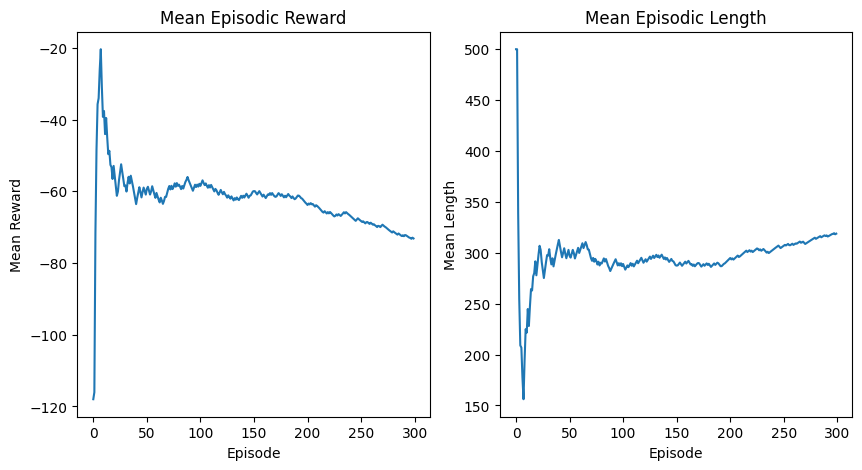

In [ ]:
plot_model_performance(mean_rewards, mean_lengths)